In [1]:
import torch
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import random
import torch.nn.init as init

random.seed(42)
torch.manual_seed(42)

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

In [2]:
# Download and load the training and test sets
trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Create DataLoader for batching the data
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False)

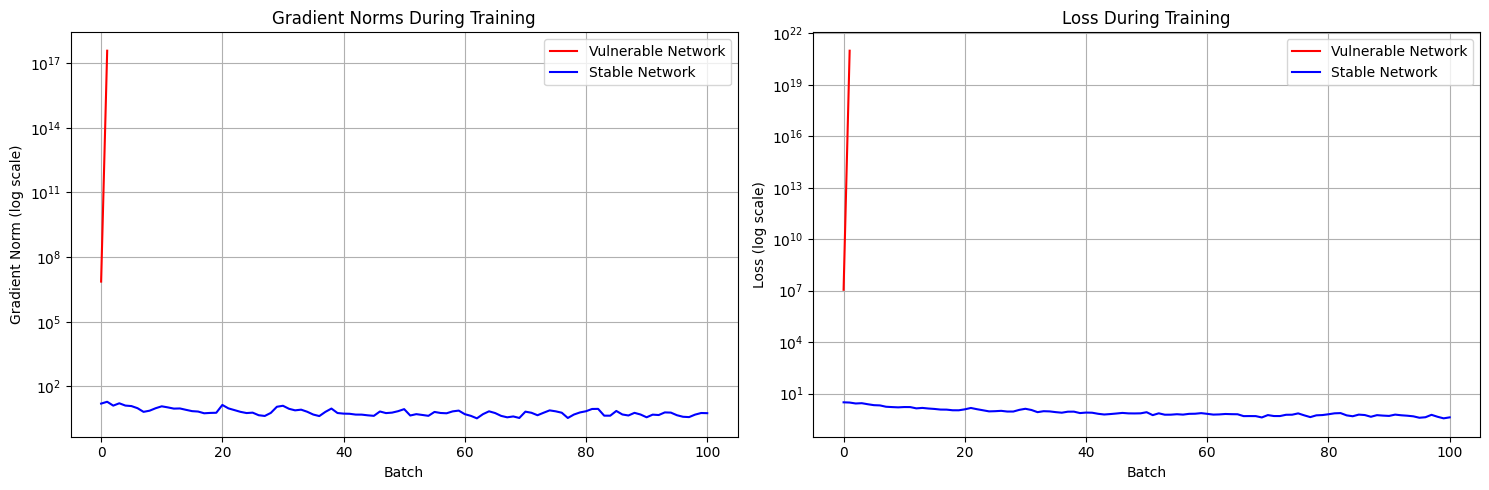

In [3]:


# Define two identical networks - one prone to exploding gradients
class VulnerableNet(nn.Module):
    def __init__(self):
        super(VulnerableNet, self).__init__()
        # Using large initial weights and deep architecture
        self.layers = nn.Sequential(
            nn.Linear(784, 1024),
            nn.ReLU(),
            nn.Linear(1024, 1024),
            nn.ReLU(),
            nn.Linear(1024, 1024),
            nn.ReLU(),
            nn.Linear(1024, 1024),
            nn.ReLU(),
            nn.Linear(1024, 10)
        )
        
        # Initialize weights with large values
        for layer in self.layers:
            if isinstance(layer, nn.Linear):
                nn.init.normal_(layer.weight, mean=0, std=1.0)
    
    def forward(self, x):
        x = x.view(-1, 784)
        return self.layers(x)

class StableNet(nn.Module):
    def __init__(self):
        super(StableNet, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(784, 1024),
            nn.ReLU(),
            nn.Linear(1024, 1024),
            nn.ReLU(),
            nn.Linear(1024, 1024),
            nn.ReLU(),
            nn.Linear(1024, 1024),
            nn.ReLU(),
            nn.Linear(1024, 10)
        )
        
        # Initialize weights properly
        for layer in self.layers:
            if isinstance(layer, nn.Linear):
                nn.init.kaiming_normal_(layer.weight)

    def forward(self, x):
        x = x.view(-1, 784)
        return self.layers(x)

def train_and_monitor(model, name):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01)
    
    gradient_norms = []
    losses = []
    
    for batch_idx, (data, target) in enumerate(trainloader):
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        
        # Calculate gradient norm
        total_norm = 0
        for p in model.parameters():
            if p.grad is not None:
                param_norm = p.grad.data.norm(2)
                total_norm += param_norm.item() ** 2
        total_norm = total_norm ** 0.5
        
        gradient_norms.append(total_norm)
        losses.append(loss.item())
        
        optimizer.step()
        
        if batch_idx >= 100:  # Monitor first 100 batches
            break
            
    return gradient_norms, losses

# Train both networks and collect metrics
vulnerable_net = VulnerableNet()
stable_net = StableNet()

vulnerable_grads, vulnerable_losses = train_and_monitor(vulnerable_net, "Vulnerable")
stable_grads, stable_losses = train_and_monitor(stable_net, "Stable")

# Plotting functions
def plot_metrics():
    plt.figure(figsize=(15, 5))
    
    # Plot gradient norms
    plt.subplot(1, 2, 1)
    plt.plot(vulnerable_grads, label='Vulnerable Network', color='red')
    plt.plot(stable_grads, label='Stable Network', color='blue')
    plt.yscale('log')
    plt.title('Gradient Norms During Training')
    plt.xlabel('Batch')
    plt.ylabel('Gradient Norm (log scale)')
    plt.legend()
    plt.grid(True)
    
    # Plot losses
    plt.subplot(1, 2, 2)
    plt.plot(vulnerable_losses, label='Vulnerable Network', color='red')
    plt.plot(stable_losses, label='Stable Network', color='blue')
    plt.yscale('log')
    plt.title('Loss During Training')
    plt.xlabel('Batch')
    plt.ylabel('Loss (log scale)')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

# Generate plots
plot_metrics()